# Revenue Equivalence

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 

plt.rcParams.update({"text.usetex": True, 'font.size':14})

np.random.seed(1337)

from scipy import stats

# Illustrating the Revenue Equivalence Theorem 

In [2]:
N = 5
R = 100000

In [3]:
np.random.seed(1337)
v = np.random.uniform(0,1,(N,R))

In [4]:
# BNE in first-price sealed bid
b_star = lambda vi,N: (N-1)/N * vi
b = b_star(v,N)

### Continuing work 

In [5]:
idx = np.argsort(v, axis=0)
v = np.take_along_axis(v, idx, axis=0) # same as np.sort(v, axis=0), except now we retian idx 
b = np.take_along_axis(b, idx, axis=0)

ii = np.repeat(np.arange(1,N+1)[:,None], R, axis=1)
ii = np.take_along_axis(ii, idx, axis=0)

winning_player = ii[-1,:]

winner_pays_fpsb = b[-1, :] # highest bid 
winner_pays_spsb = v[-2, :] # 2nd-highest valuation

Avg. payment FPSB:  0.66652 (std.dev. =  0.11)
Avg. payment SPSB:  0.66670 (std.dev. =  0.18)


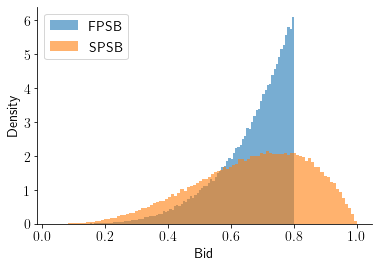

In [6]:
fig,ax = plt.subplots(); 
for x,lab in zip([winner_pays_fpsb,winner_pays_spsb], ['FPSB', 'SPSB']): 
    print(f'Avg. payment {lab}: {x.mean(): 8.5f} (std.dev. = {np.sqrt(x.var()): 5.2f})')
    ax.hist(x, density=True, alpha=0.6, label=lab, bins=100); 
ax.legend(loc='best'); ax.set_xlabel('Bid'); ax.set_ylabel('Density'); sns.despine()

In [7]:
binned = stats.binned_statistic(v[-1, :], v[-2, :], statistic='mean', bins=20)
xx = binned.bin_edges
xx = [(xx[i]+xx[i+1])/2 for i in range(len(xx)-1)]
yy = binned.statistic

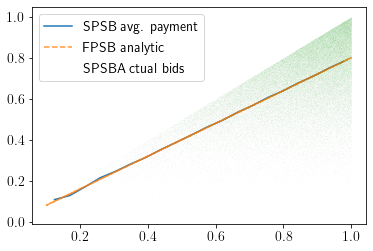

In [8]:
fig,ax = plt.subplots(); 
ax.plot(xx, yy,                        label='SPSB avg. payment'); 
ax.plot(v[-1, :], b[-1, :], '--', alpha=0.8, label='FPSB analytic'); 
ax.plot(v[-1, :], v[-2, :], 'o', alpha=0.05, markersize=.1, label='SPSBA ctual bids'); 
ax.legend(loc='best'); 

## A quick look through pandas

In [9]:
mat = (v.T, b.T)
mat = np.hstack(mat)
v_ = [f'v{i+1}' for i in range(N)]
b_ = [f'b{i+1}' for i in range(N)]
dat = pd.DataFrame(mat, columns = v_ + b_)
dat.index.name = 'r'

In [10]:
dat[v_].head(5)

,v1,v2,v3,v4,v5
r,,,,,
0,0.262025,0.436078,0.667935,0.930770,0.991727
1,0.004887,0.158684,0.261774,0.334389,0.582017
2,0.081071,0.247090,0.278127,0.770553,0.845722
3,0.010873,0.045481,0.459317,0.581799,0.875999
4,0.321001,0.363505,0.607044,0.789102,0.928140


In [11]:
dat[v_].max(1).head(5)

r
0    0.991727
1    0.582017
2    0.845722
3    0.875999
4    0.928140
dtype: float64

In [12]:
dat['v4'].mean()

0.6666970469433559

In [13]:
dat['b5'].mean()

0.6665162948142672

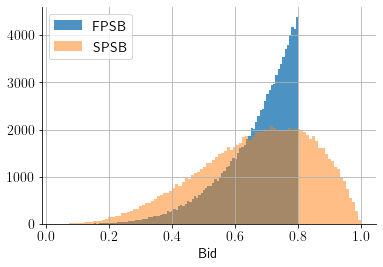

In [14]:
fig,ax = plt.subplots(); 
dat['b5'].hist(bins=100, ax=ax, alpha=0.8, label='FPSB');
dat['v4'].hist(bins=100, ax=ax, alpha=0.5, label='SPSB');
ax.legend(); sns.despine(); ax.set_xlabel('Bid'); 

## Solving numerically 

## Linear interpolation: a reminder

Consists of two steps: 
1. preparing the interpolator: runs precomputation and returns a function handle. Call `interpolate.interp1d`. 
2. evaluating the interpolator. 

In [15]:
from scipy import interpolate 

In [16]:
xx = np.linspace(0,1,10)
yy = xx ** 2 # the "unknown" function

# prepare interpolation function (precomputation)
f_ = interpolate.interp1d(xx,yy,kind='linear')

# evaluate 
#plt.plot(xx,yy,'o', xx,f_(xx), '-x'); 

## Expectation of the 2nd order statistic

Our procedure is the following: 

* Input: \bar{v}: the lower truncation value, $R$: the # of draws. 
1. Draw $v_{r}$ for draws $r = 1,...,R$. 
2. Subset, choosing $\mathcal{R} \equiv \{ r \in \{1,...,R\} \vert v_{r} \le \bar{v} \}$
3. Reshape dataset to $v_{i,r}$ for $i = 1,...,N$ and $r = 1,..., \tilde{R}$. 
    * *Note:* We will have to throw away some of the very last observations to have a square matrix. Specifically, we throw away the last mod$(\vert \mathcal{R} \vert, N)$ simulated draws. 
4. For each simulation, $r \in \mathcal{R}$, find the 2nd largest value, $v_{(n-1),r}$
5. Return $\hat{\mathbb{E}}(v_{(n-1)}) = R^{-1} \sum_{r=1}^R v_{(n-1),r}$. 

In [17]:
def Ev_largest(vi, v_sim_untruncated, N, R_used_min=42): 
    '''Ev_largest: compute the expected value of 
        
        INPUTS: 
            vi: (scalar) upper truncation point 
            v_sim_untruncated: (R-length 1-dim np array) draws of v from the untruncated distribution
            N: (int) number of draws per iteration  
            R_used_min: (int, optional) assert that we have at least this many samples. (Set =0 to disable.)
            
        OUTPUTS
            Ev: (float) expected value of the 2nd largest across simulations
            R_used: (int) no. replications used to compute simulated expectation
    '''
    assert v_sim_untruncated.ndim == 1, f'Expected 1-dimensional array'
    
    # perform truncation 
    I = v_sim_untruncated <= vi
    v_sim = np.copy(v_sim_untruncated[I])

    # drop extra rows
    drop_this_many = np.mod(v_sim.size, N)
    if drop_this_many>0: 
        v_sim = v_sim[:-drop_this_many]
    
    # reshape
    R_used = int(v_sim.size / N)
    v_sim = np.reshape(v_sim, (N,R_used))
    assert R_used > R_used_min, f'Too few replications included: only {R_used}. Try increasing original R.'
    
    # find 2nd largest value 
    #v_sim = np.sort(v_sim, 0)   # sorts ascending
    #v_largest = v_sim[-1, :] # 2nd last col is the 2nd highest
    v_largest = v_sim.max(0)
    
    # evaluate expectation
    Ev = np.mean(v_largest)
    
    return Ev

## Proof that it works: uniforms

The convenient feature of auctions with uniformly distributed valuations is that we can solve for the Bayesian Nash Equilibrium (BNE) analytically. Hence, we can compoare it to our analytical solution. 

In [18]:
R = 1000000
np.random.seed(1337)
v = np.random.uniform(0,1,(N,R)).flatten()

In [19]:
vgrid = np.linspace(0, 1, 10, endpoint=False)[1:]
Ev = np.empty((vgrid.size,))

for i,this_v in enumerate(vgrid): 
    Ev[i] = Ev_largest(this_v, v, N-1) # Crucially: we draw *one less* obs. per simulated sample

Plotting the results against the analytic solution. 

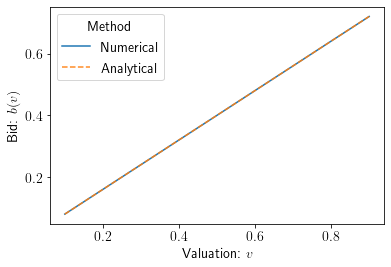

In [20]:
fig, ax = plt.subplots(); 

ax.plot(vgrid, Ev,               '-', label='Numerical'); 
ax.plot(vgrid, b_star(vgrid, N), '--', label='Analytical', alpha=0.9); 

ax.legend(loc='best', title='Method'); 
ax.set_ylabel('Bid: $b(v)$'); ax.set_xlabel('Valuation: $v$'); 

## $\chi^2$ distributed errors 

Here, it is somewhat harder to solve for the optimal bidding

In [34]:
np.random.seed(1337)
v = np.random.chisquare(df=2, size=(N,R))

The distribution of drawn values 

In [ ]:
plt.hist(v[:], bins=100); plt.xlabel('Values: $v$');  

## Solve for the BNE of the First Price Sealed Bid (FPSB) auction
Using revenue equivalence. 

In [23]:
v = v.flatten()
pcts = np.linspace(0, 100, 100, endpoint=False)[1:]
vgrid = np.percentile(v, q=pcts)
Ev = np.empty(vgrid.shape)
for i,this_v in enumerate(vgrid): 
    Ev[i] = Ev_largest(this_v, v, N-1)
    
# by construction / assumption, the lowest-valued bidder always pays zero
Ev    = np.insert(Ev, 0, 0.0)
vgrid = np.insert(vgrid, 0, 0)

# set up interpolation function for the solution
b_star_num = interpolate.interp1d(vgrid, Ev, fill_value='extrapolate')

Show the solution over the grid 

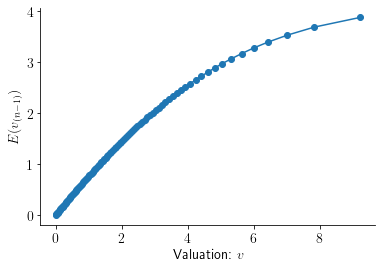

In [24]:
fig,ax = plt.subplots(); 
ax.plot(vgrid, Ev, '-o'); ax.set_xlabel('Valuation: $v$'); ax.set_ylabel('$E(v_{(n-1)})$'); sns.despine(); 

In [25]:
v = v.reshape((N,R))

In [26]:
b = b_star_num(v)

In [27]:
idx = np.argsort(v, axis=0)
v = np.take_along_axis(v, idx, axis=0) # same as np.sort(v, axis=0), except now we retian idx 
b = np.take_along_axis(b, idx, axis=0)

ii = np.repeat(np.arange(1,N+1)[:,None], R, axis=1)
ii = np.take_along_axis(ii, idx, axis=0)

winning_player = ii[-1,:]

winner_pays_fpsb = b[-1, :] # highest bid 
winner_pays_spsb = v[-2, :] # 2nd-highest valuation

In [28]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Avg. payment FPSB:  2.57286 (std.dev. =  0.84)
Avg. payment SPSB:  2.56558 (std.dev. =  1.36)


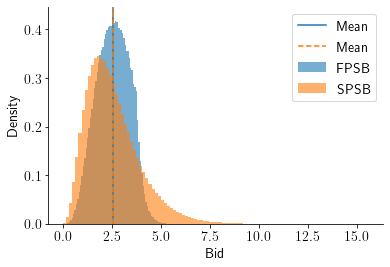

In [31]:
fig,ax = plt.subplots(); 
for x,lab in zip([winner_pays_fpsb,winner_pays_spsb], ['FPSB', 'SPSB']): 
    # compute avg. and std.dev. of payment
    print(f'Avg. payment {lab}: {x.mean(): 8.5f} (std.dev. = {np.sqrt(x.var()): 5.2f})')
    
    # show histogram 
    ax.hist(x, density=True, alpha=0.6, label=lab, bins=100); 

# also show the average payment
ax.axvline(winner_pays_fpsb.mean(), color=colors[0], linestyle='-', label='Mean'); 
ax.axvline(winner_pays_spsb.mean(), color=colors[1], linestyle='--', label='Mean'); 

# to make nice 
ax.legend(loc='best'); ax.set_xlabel('Bid'); ax.set_ylabel('Density'); sns.despine()